# BTC-USD @24h

In [1]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
STOCKS = [
    'amd',
    'nvda',
    'gbtc',
    'mara',
    'ostk',
    'otiv',
    'riot',
    'sieb',
]
STOCKS_FILENAMES = {s: './data_clean/' + s + '.csv'
                    for s in STOCKS}
# OUT_FILENAME = './results/'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [4]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> BTC-USD: 1324 data points
  from 2015-02-28 00:00:00 to 2018-10-13 00:00:00


,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-28,253.0,253.1,254.3,245.2,3.61,0


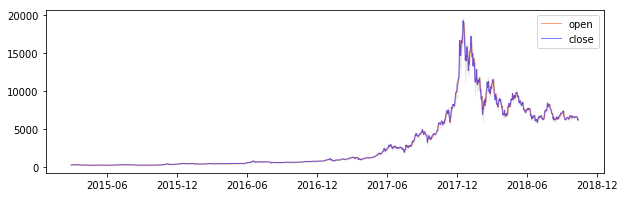

In [5]:
data_btc = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
data_btc = data_btc[data_btc.index >= '2015-02-28']
print("> BTC-USD: %d data points" % (len(data_btc),))
print("  from %s to %s" % (data_btc.iloc[0].name, data_btc.iloc[-1].name))
simple_plot(data_btc, show_xlabels=False)
dd(data_btc.head(1))



---------
> stock OSTK: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


,close,volume,open,high,low,missing,weekday,close_btc,slope_btc,r2_btc
datetime,,,,,,,,,,
2018-10-11,24.86,1809443.0,25.15,25.89,24.14,0.0,3,6161.0,1.055235e-13,0.274803
2018-10-12,26.40,1250256.0,25.38,26.44,24.77,0.0,4,6184.9,-2.280879e-13,0.156982


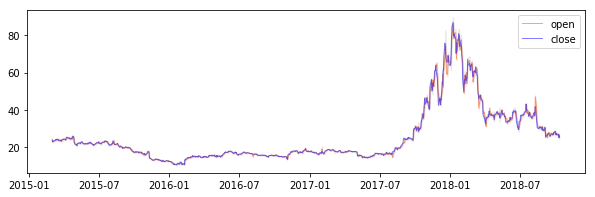



---------
> stock RIOT: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


,close,volume,open,high,low,missing,weekday,close_btc,slope_btc,r2_btc
datetime,,,,,,,,,,
2018-10-11,2.16,662046.0,2.15,2.3204,2.15,0.0,3,6161.0,1.055235e-13,0.274803
2018-10-12,2.57,4981702.0,2.22,3.1100,2.22,0.0,4,6184.9,-2.280879e-13,0.156982


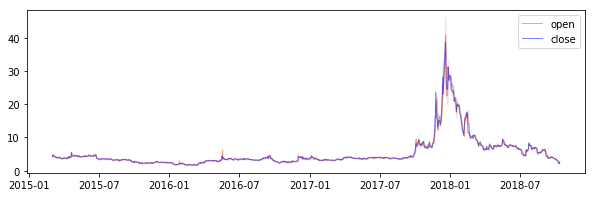



---------
> stock AMD: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


,close,volume,open,high,low,missing,weekday,close_btc,slope_btc,r2_btc
datetime,,,,,,,,,,
2018-10-11,25.30,146516800.0,24.74,26.2000,24.55,0.0,3,6161.0,1.055235e-13,0.274803
2018-10-12,26.34,110862700.0,26.77,26.9697,25.67,0.0,4,6184.9,-2.280879e-13,0.156982


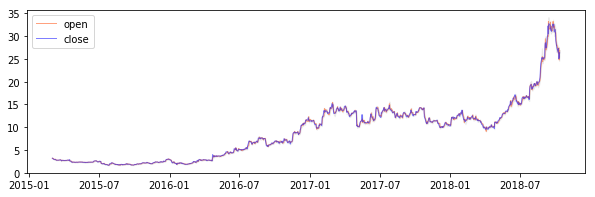



---------
> stock OTIV: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


,close,volume,open,high,low,missing,weekday,close_btc,slope_btc,r2_btc
datetime,,,,,,,,,,
2018-10-11,0.9112,74004.0,0.94,0.94,0.855,0.0,3,6161.0,1.055235e-13,0.274803
2018-10-12,0.9400,64730.0,0.91,0.94,0.886,0.0,4,6184.9,-2.280879e-13,0.156982


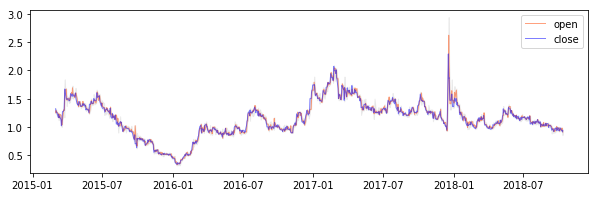



---------
> stock NVDA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


,close,volume,open,high,low,missing,weekday,close_btc,slope_btc,r2_btc
datetime,,,,,,,,,,
2018-10-11,235.13,18063810.0,242.1700,247.5600,234.261,0.0,3,6161.0,1.055235e-13,0.274803
2018-10-12,246.54,15121060.0,245.5066,249.5412,239.650,0.0,4,6184.9,-2.280879e-13,0.156982


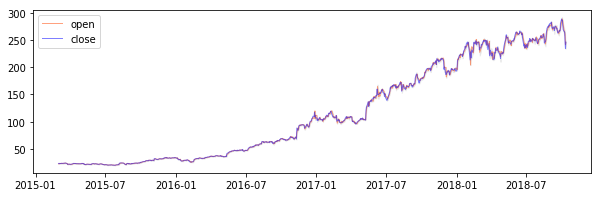



---------
> stock SIEB: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


,close,volume,open,high,low,missing,weekday,close_btc,slope_btc,r2_btc
datetime,,,,,,,,,,
2018-10-11,12.96,10389.0,13.00,13.46,12.95,0.0,3,6161.0,1.055235e-13,0.274803
2018-10-12,13.09,10455.0,13.27,13.87,13.02,0.0,4,6184.9,-2.280879e-13,0.156982


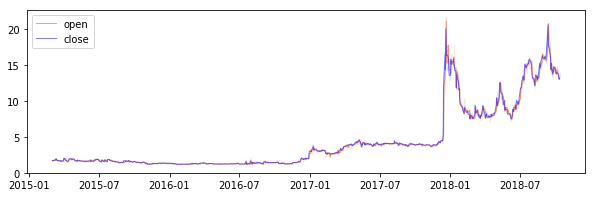



---------
> stock GBTC: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


,close,volume,open,high,low,missing,weekday,close_btc,slope_btc,r2_btc
datetime,,,,,,,,,,
2018-10-11,6.78,2474177.0,6.990,6.99,6.75,0.0,3,6161.0,1.055235e-13,0.274803
2018-10-12,6.85,1168809.0,6.865,6.99,6.78,0.0,4,6184.9,-2.280879e-13,0.156982


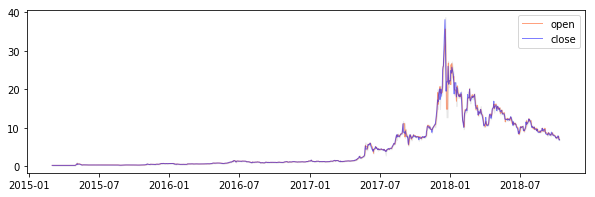



---------
> stock MARA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


,close,volume,open,high,low,missing,weekday,close_btc,slope_btc,r2_btc
datetime,,,,,,,,,,
2018-10-11,0.5850,734764.0,0.63,0.630,0.57,0.0,3,6161.0,1.055235e-13,0.274803
2018-10-12,0.6085,698911.0,0.60,0.678,0.59,0.0,4,6184.9,-2.280879e-13,0.156982


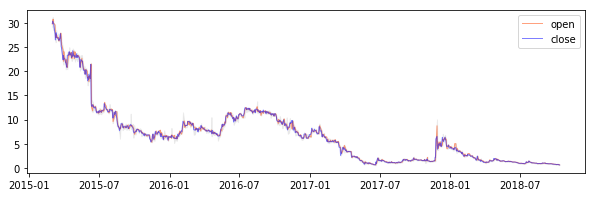

In [6]:
stocks_data = {}
for stock, filename in STOCKS_FILENAMES.items():
    data = pd.read_csv(
        filename,
        index_col='datetime',
        parse_dates=['datetime']
    )
    data = data[data.index >= '2015-02-28']
    data['weekday'] = data.index.dayofweek
    data = etl.augment(data, data_btc, 7, '_btc')
    stocks_data[stock] = data
    print("\n\n---------")
    print("> stock %s: %d data points" % (stock.upper(), len(data)))
    print("  from %s to %s" % (data.iloc[0].name, data.iloc[-1].name))
    dd(data.tail(2))
    simple_plot(data, show_xlabels=False)
    plt.show()

## Experiments

### Figure out what/if extra features can be usefull



        #################################
        # ostk
        #################################
        
data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140037368842384
Tensor("lstm_93_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_93 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_94 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_94 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 4         
Total params:

Train on 277 samples, validate on 15 samples
Epoch 1/4
277/277 [==============================] - 9s 32ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 2/4
277/277 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 3/4
277/277 [==============================] - 0s 777us/step - loss: 0.0030 - val_loss: 0.0021
Epoch 4/4
277/277 [==============================] - 0s 769us/step - loss: 0.0029 - val_loss: 0.0021
--- 10.957s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (n

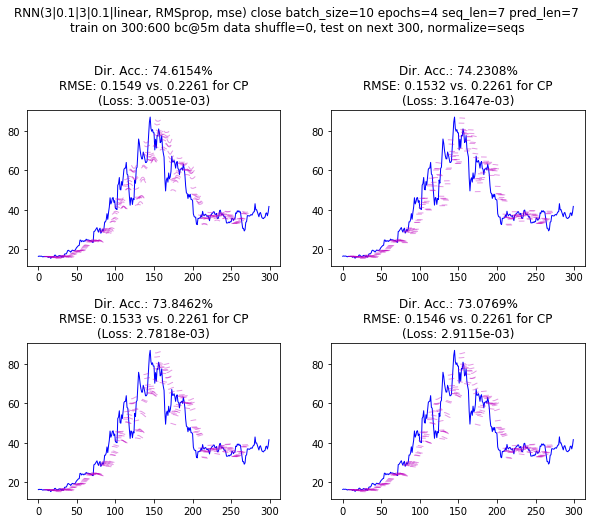

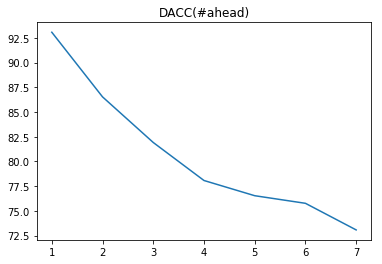

--- 60.740s to run experiment



In [35]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close'],
            from_i=300,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=4,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break



        #################################
        # ostk
        #################################
        
data ~ (600, 2)
--- 0.017s to model compilation time


--- Created model id: 140037628685136
Tensor("lstm_63_input:0", shape=(?, 7, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 7, 3)              72        
_________________________________________________________________
dropout_63 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_64 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 4         
Total params:

Train on 277 samples, validate on 15 samples
Epoch 1/5
277/277 [==============================] - 7s 23ms/step - loss: 0.0065 - val_loss: 0.0024
Epoch 2/5
277/277 [==============================] - 0s 791us/step - loss: 0.0067 - val_loss: 0.0026
Epoch 3/5
277/277 [==============================] - 0s 784us/step - loss: 0.0064 - val_loss: 0.0025
Epoch 4/5
277/277 [==============================] - ETA: 0s - loss: 0.006 - 0s 717us/step - loss: 0.0057 - val_loss: 0.0023
Epoch 5/5
277/277 [==============================] - 0s 761us/step - loss: 0.0060 - val_loss: 0.0027
--- 8.821s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Pre

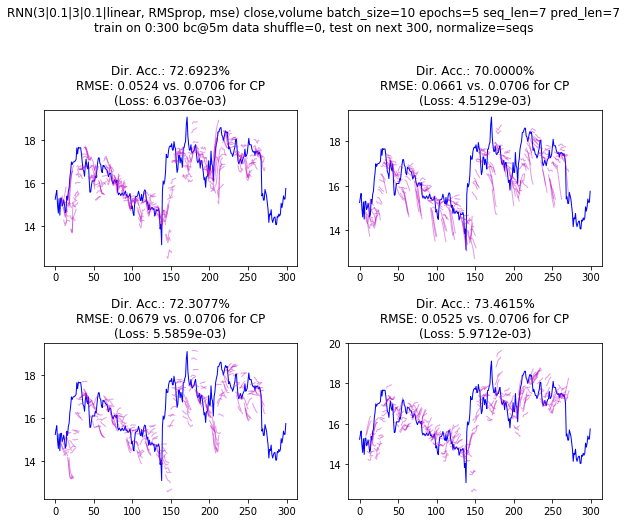

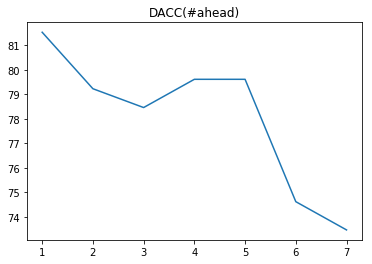

--- 46.528s to run experiment



In [26]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'volume'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=5,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break



        #################################
        # ostk
        #################################
        
data ~ (600, 2)
--- 0.017s to model compilation time


--- Created model id: 140037298907216
Tensor("lstm_101_input:0", shape=(?, 7, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_101 (LSTM)              (None, 7, 6)              216       
_________________________________________________________________
dropout_101 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_102 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_102 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 7         
Total params

Train on 277 samples, validate on 15 samples
Epoch 1/4
277/277 [==============================] - 10s 35ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 2/4
277/277 [==============================] - 0s 956us/step - loss: 0.0039 - val_loss: 0.0023
Epoch 3/4
277/277 [==============================] - 0s 785us/step - loss: 0.0034 - val_loss: 0.0022
Epoch 4/4
277/277 [==============================] - 0s 811us/step - loss: 0.0033 - val_loss: 0.0022
--- 13.514s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting

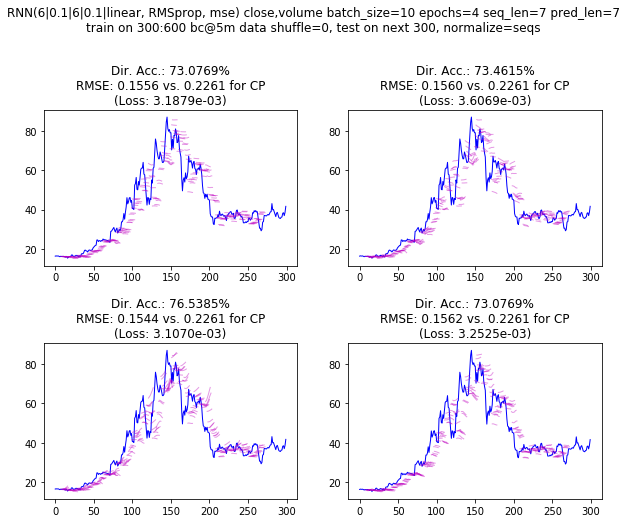

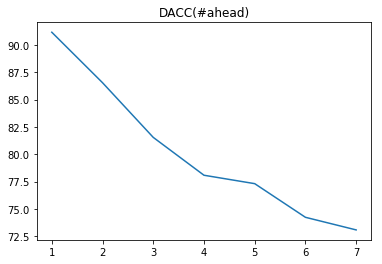

--- 65.762s to run experiment



In [36]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'volume'],
            from_i=300,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([6, 0.1, 6, 0.1]),
            # training:
            epochs=4,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break



        #################################
        # ostk
        #################################
        
data ~ (900, 2)
--- 0.017s to model compilation time


--- Created model id: 140037276546768
Tensor("lstm_113_input:0", shape=(?, 7, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_113 (LSTM)              (None, 7, 6)              216       
_________________________________________________________________
dropout_113 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_114 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_114 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 7         
Total params

Train on 562 samples, validate on 30 samples
Epoch 1/4
562/562 [==============================] - 11s 19ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 2/4
562/562 [==============================] - 0s 722us/step - loss: 0.0039 - val_loss: 0.0033
Epoch 3/4
562/562 [==============================] - 0s 887us/step - loss: 0.0039 - val_loss: 0.0031
Epoch 4/4
562/562 [==============================] - 0s 859us/step - loss: 0.0035 - val_loss: 0.0031
--- 13.803s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting

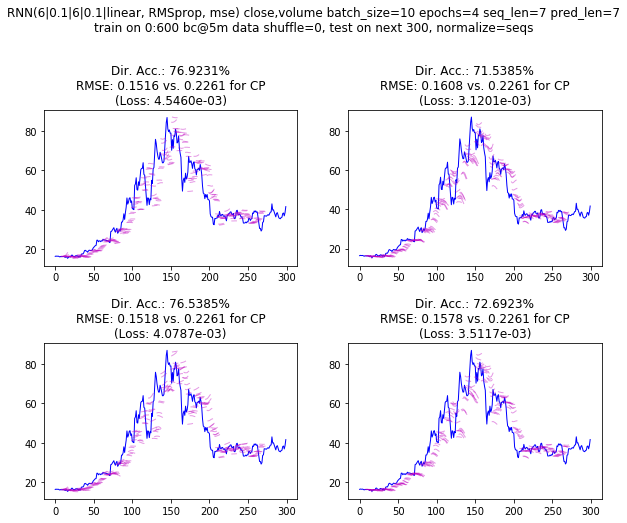

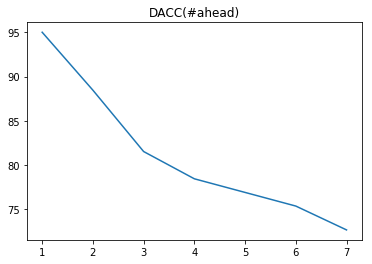

--- 75.919s to run experiment



In [39]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'volume'],
            from_i=0,
            train_sz=600,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([6, 0.1, 6, 0.1]),
            # training:
            epochs=4,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break



        #################################
        # ostk
        #################################
        
data ~ (900, 2)
--- 0.017s to model compilation time


--- Created model id: 140037241286992
Tensor("lstm_185_input:0", shape=(?, 7, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_185 (LSTM)              (None, 7, 6)              216       
_________________________________________________________________
dropout_185 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_186 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_186 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 7         
Total params

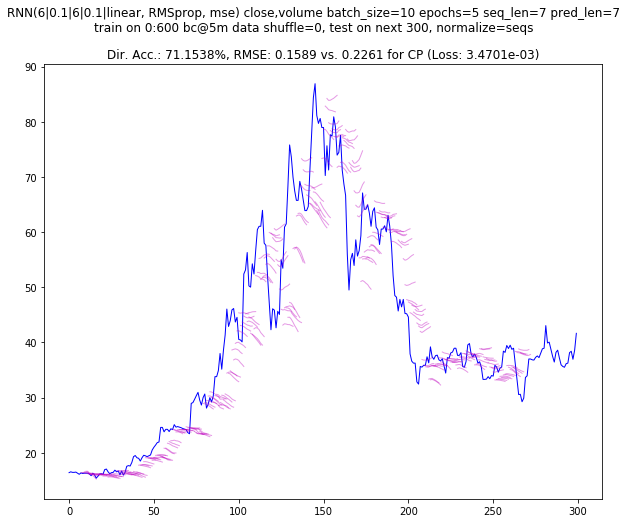

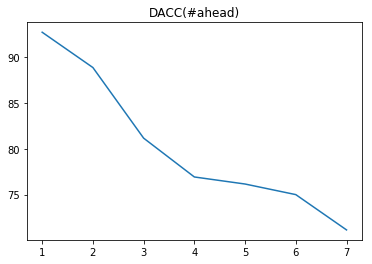

--- 28.494s to run experiment



        #################################
        # riot
        #################################
        
data ~ (900, 2)
--- 0.017s to model compilation time


--- Created model id: 140036363601680
Tensor("lstm_187_input:0", shape=(?, 7, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_187 (LSTM)              (None, 7, 6)              216       
_________________________________________________________________
dropout_187 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_188 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_188 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)         

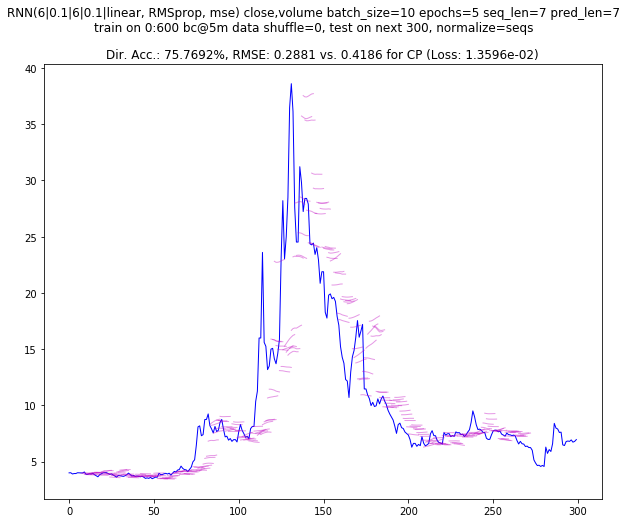

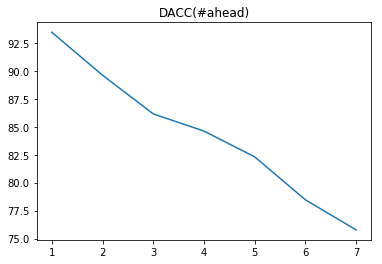

--- 27.880s to run experiment



In [48]:
for stock in ['ostk', 'riot']:
    data = stocks_data[stock]
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'volume'],
            from_i=0,
            train_sz=600,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([6, 0.1, 6, 0.1]),
            # training:
            epochs=5,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=1,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (900, 5)
--- 0.030s to model compilation time


--- Created model id: 140036299222416
Tensor("lstm_213_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_213 (LSTM)              (None, 7, 9)              540       
_________________________________________________________________
dropout_213 (Dropout)        (None, 7, 9)              0         
_________________________________________________________________
lstm_214 (LSTM)              (None, 9)                 684       
_________________________________________________________________
dropout_214 (Dropout)        (None, 9)                 0         
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 10        
Total params

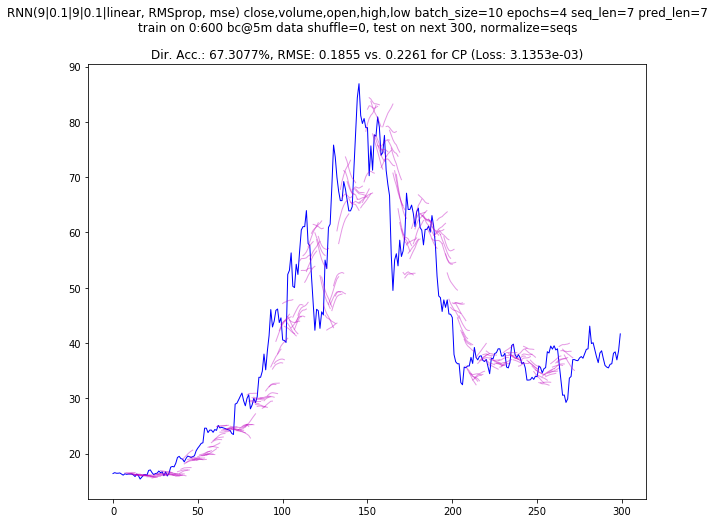

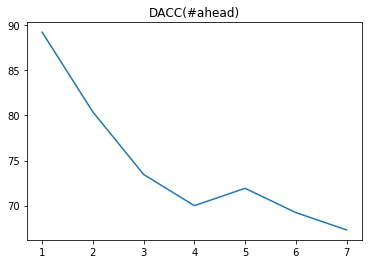

--- 33.908s to run experiment



        #################################
        # riot
        #################################
        
data ~ (900, 5)
--- 0.031s to model compilation time


--- Created model id: 140036124769168
Tensor("lstm_215_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_215 (LSTM)              (None, 7, 9)              540       
_________________________________________________________________
dropout_215 (Dropout)        (None, 7, 9)              0         
_________________________________________________________________
lstm_216 (LSTM)              (None, 9)                 684       
_________________________________________________________________
dropout_216 (Dropout)        (None, 9)                 0         
_________________________________________________________________
dense_108 (Dense)            (None, 1)         

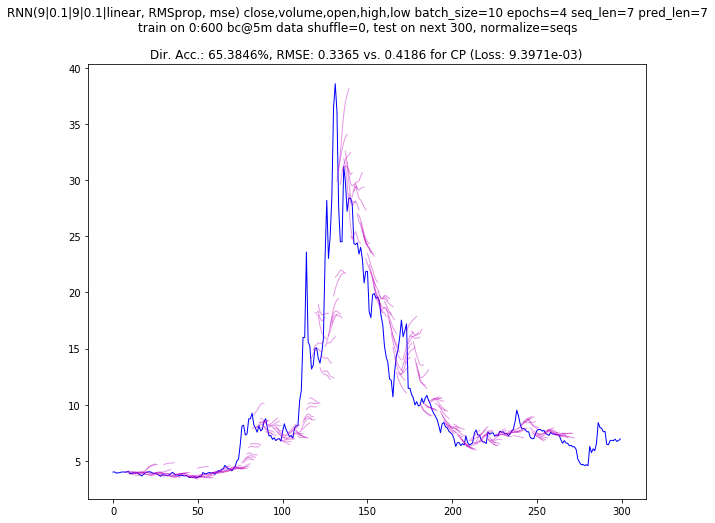

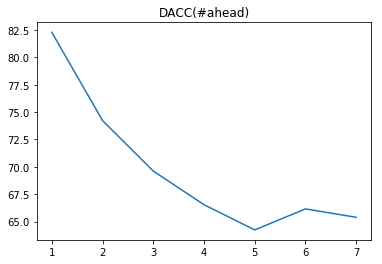

--- 33.617s to run experiment



In [55]:
for stock in ['ostk', 'riot']:
    data = stocks_data[stock]
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'volume', 'open', 'high', 'low'],
            from_i=0,
            train_sz=600,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([9, 0.1, 9, 0.1]),
            # training:
            epochs=3,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=1,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (900, 3)
--- 0.025s to model compilation time


--- Created model id: 140036385413712
Tensor("lstm_221_input:0", shape=(?, 7, 3), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_221 (LSTM)              (None, 7, 6)              240       
_________________________________________________________________
dropout_221 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_222 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_222 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 7         
Total params

Train on 562 samples, validate on 30 samples
Epoch 1/5
562/562 [==============================] - 22s 39ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 2/5
562/562 [==============================] - 1s 963us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 3/5
562/562 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 4/5
562/562 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 5/5
562/562 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0041
--- 26.533s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Pr

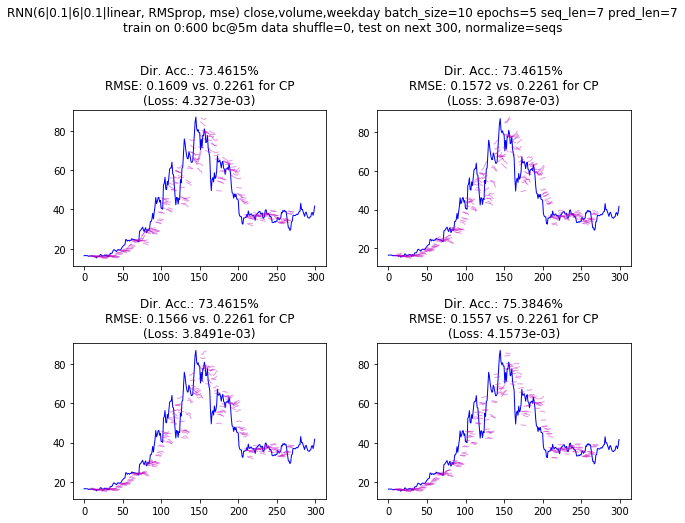

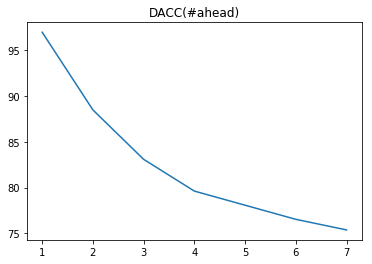

--- 143.635s to run experiment



        #################################
        # riot
        #################################
        
data ~ (900, 3)
--- 0.017s to model compilation time


--- Created model id: 140035970030608
Tensor("lstm_229_input:0", shape=(?, 7, 3), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_229 (LSTM)              (None, 7, 6)              240       
_________________________________________________________________
dropout_229 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_230 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_230 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_115 (Dense)            (None, 1)        

Train on 562 samples, validate on 30 samples
Epoch 1/5
562/562 [==============================] - 22s 40ms/step - loss: 0.0160 - val_loss: 0.0020
Epoch 2/5
562/562 [==============================] - 1s 902us/step - loss: 0.0135 - val_loss: 0.0018
Epoch 3/5
562/562 [==============================] - 1s 907us/step - loss: 0.0125 - val_loss: 0.0017
Epoch 4/5
562/562 [==============================] - 1s 933us/step - loss: 0.0119 - val_loss: 0.0016
Epoch 5/5
562/562 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0017
--- 26.924s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...


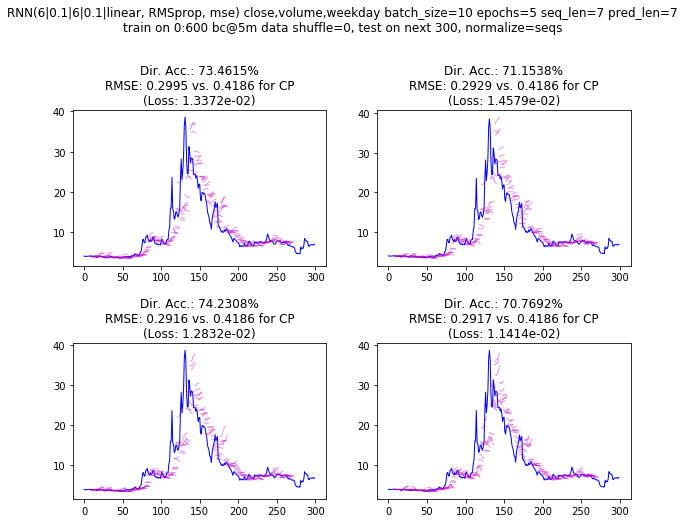

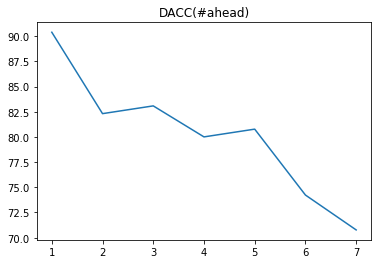

--- 162.010s to run experiment



In [57]:
for stock in ['ostk', 'riot']:
    data = stocks_data[stock]
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=[
                'close', 'volume',
#                 'open', 'high', 'low',
                'weekday'
            ],
            from_i=0,
            train_sz=600,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([6, 0.1, 6, 0.1]),
            # training:
            epochs=5,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (900, 5)
--- 0.018s to model compilation time


--- Created model id: 140036146729488
Tensor("lstm_241_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_241 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_241 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_242 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_242 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 7         
Total params

Train on 562 samples, validate on 30 samples
Epoch 1/5
562/562 [==============================] - 26s 47ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 2/5
562/562 [==============================] - 0s 851us/step - loss: 0.0053 - val_loss: 0.0036
Epoch 3/5
562/562 [==============================] - 1s 988us/step - loss: 0.0047 - val_loss: 0.0037
Epoch 4/5
562/562 [==============================] - 1s 951us/step - loss: 0.0047 - val_loss: 0.0039
Epoch 5/5
562/562 [==============================] - 1s 961us/step - loss: 0.0045 - val_loss: 0.0038
--- 31.691s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)..

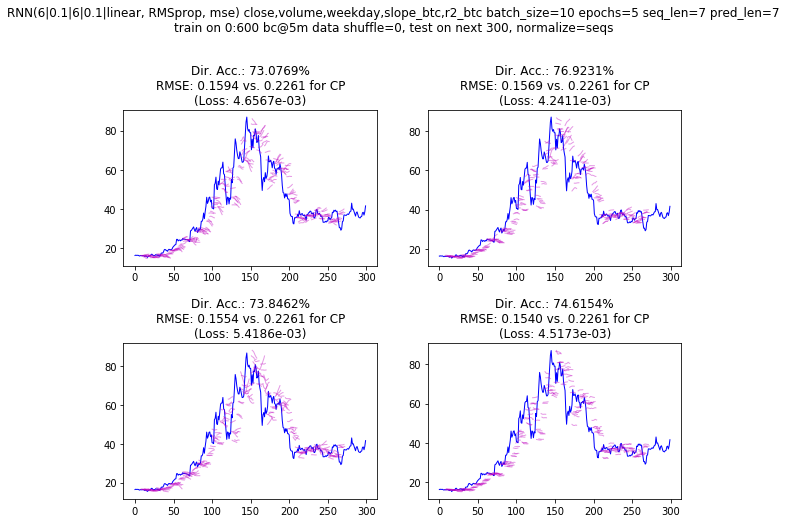

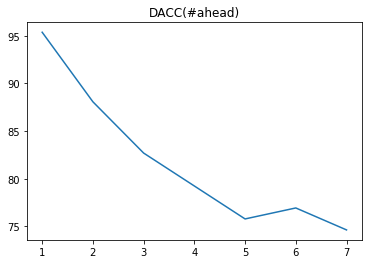

--- 158.776s to run experiment



        #################################
        # riot
        #################################
        
data ~ (900, 5)
--- 0.019s to model compilation time


--- Created model id: 140035834125840
Tensor("lstm_249_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_249 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_249 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_250 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_250 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_125 (Dense)            (None, 1)        

Train on 562 samples, validate on 30 samples
Epoch 1/5
562/562 [==============================] - 23s 41ms/step - loss: 0.0207 - val_loss: 0.0080
Epoch 2/5
562/562 [==============================] - 1s 918us/step - loss: 0.0178 - val_loss: 0.0052
Epoch 3/5
562/562 [==============================] - 1s 951us/step - loss: 0.0149 - val_loss: 0.0041
Epoch 4/5
562/562 [==============================] - 1s 1ms/step - loss: 0.0145 - val_loss: 0.0033
Epoch 5/5
562/562 [==============================] - 1s 1ms/step - loss: 0.0137 - val_loss: 0.0030
--- 27.667s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> 

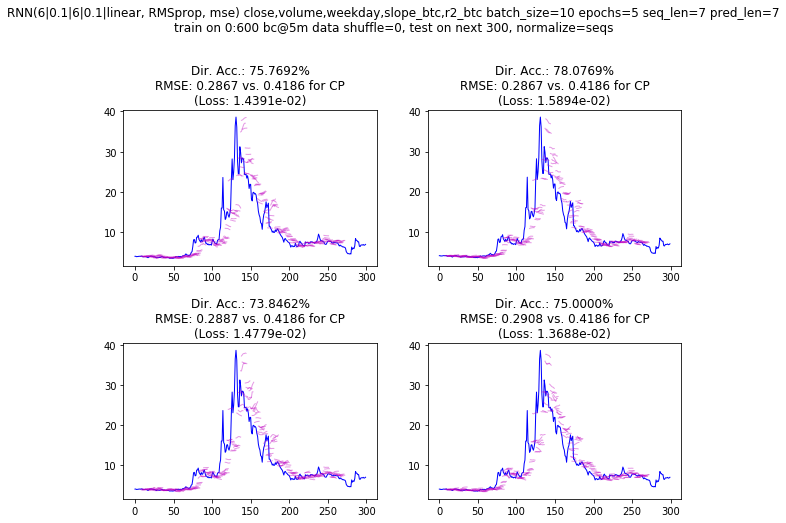

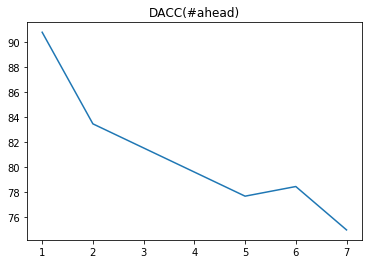

--- 157.432s to run experiment



In [59]:
for stock in ['ostk', 'riot']:
    data = stocks_data[stock]
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=[
                'close', 'volume',
#                 'open', 'high', 'low',
                'weekday',
                'slope_btc', 'r2_btc',
            ],
            from_i=0,
            train_sz=600,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([6, 0.1, 6, 0.1]),
            # training:
            epochs=5,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (900, 5)
--- 0.021s to model compilation time


--- Created model id: 140036101283024
Tensor("lstm_257_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_257 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_257 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_258 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_258 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 7         
Total params

--- 9.923s to walk and predict

--- 0.243s to plot incremental predictions

--- 0.018s to model compilation time


--- Created model id: 140035683659728
Tensor("lstm_263_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_263 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_263 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_264 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_264 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 7         
Total params: 607
Trainable params: 607
Non-trainable params: 

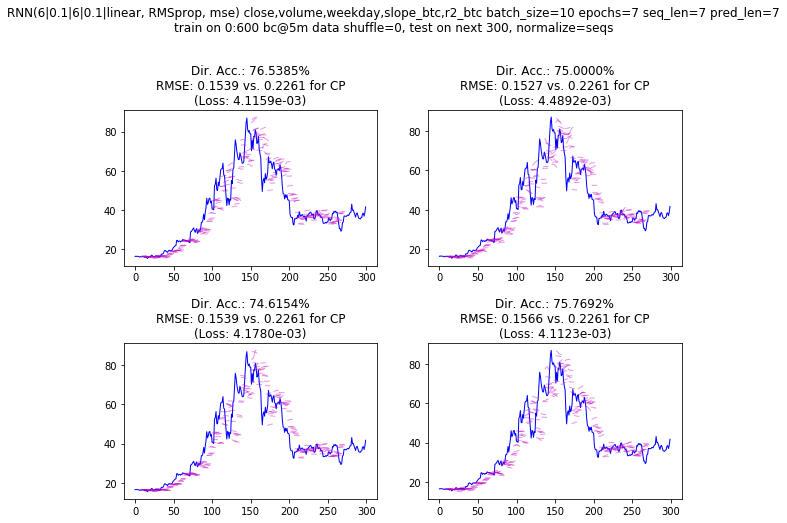

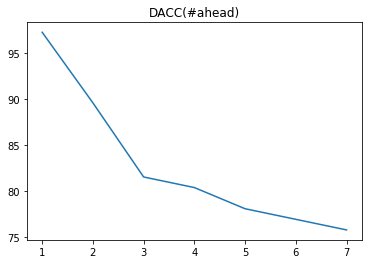

--- 170.143s to run experiment



        #################################
        # riot
        #################################
        
data ~ (900, 5)
--- 0.021s to model compilation time


--- Created model id: 140035658858320
Tensor("lstm_265_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_265 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_265 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_266 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_266 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_133 (Dense)            (None, 1)        

> Predicting (now at 240)...
> Predicting (now at 250)...
--- 10.336s to walk and predict

--- 0.242s to plot incremental predictions

--- 0.025s to model compilation time


--- Created model id: 140035596182800
Tensor("lstm_271_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_271 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_271 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_272 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_272 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 7         
Tot

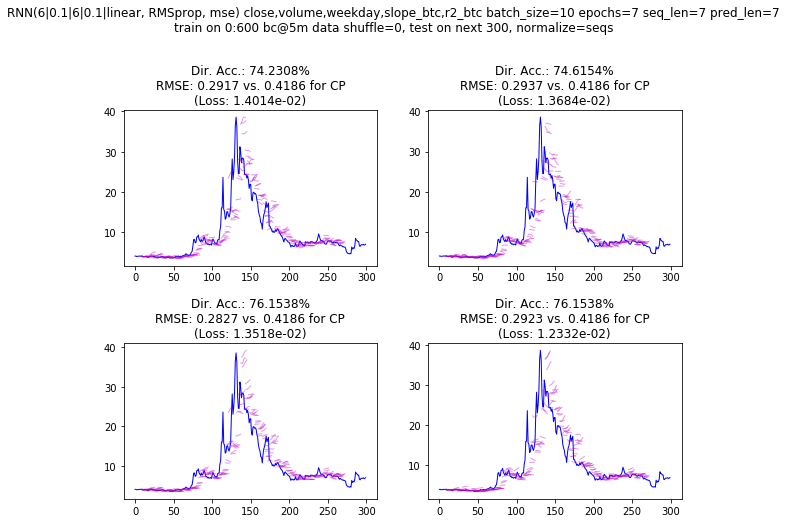

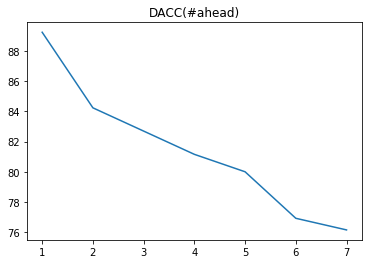

--- 173.436s to run experiment



In [60]:
for stock in ['ostk', 'riot']:
    data = stocks_data[stock]
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=[
                'close', 'volume',
#                 'open', 'high', 'low',
                'weekday',
                'slope_btc', 'r2_btc',
            ],
            from_i=0,
            train_sz=600,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([6, 0.1, 6, 0.1]),
            # training:
            epochs=7,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )

### FULL RUNS

In [61]:
DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data,
    'features': [
        'close', 'volume',
#         'open', 'high', 'low',
        'weekday',
        'slope_btc', 'r2_btc',
    ],
    'train_sz': 600,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([6, 0.1, 6, 0.1]),
    # training:
    'epochs': 7,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [63]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

def full_run(idx_from, idx_to, data, out_filename, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(out_filename, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          data_df=data,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()



        #################################
        # ostk
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 5)
--- 0.019s to model compilation time


--- Created model id: 140036015290320
Tensor("lstm_273_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_273 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_273 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_274 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_274 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_137 (Dense)     

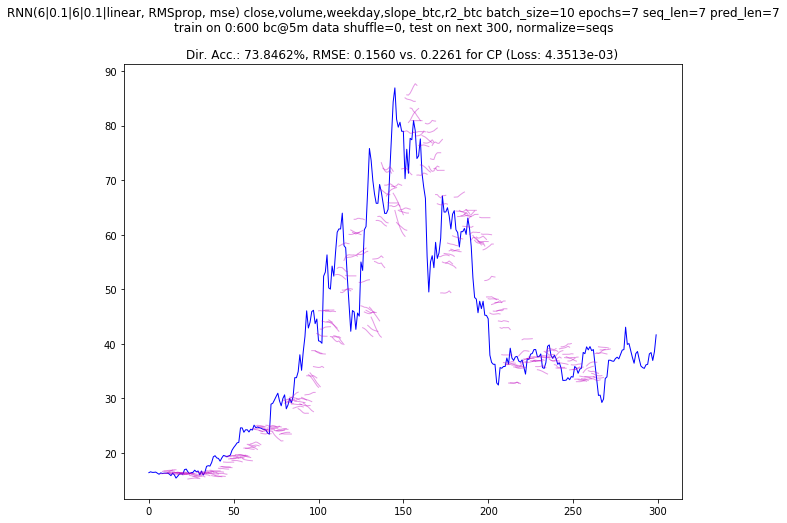

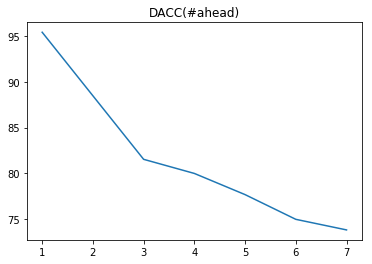

--- 44.475s to run segment

--- 44.475s to full run 600 - 645



        #################################
        # riot
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 5)
--- 0.019s to model compilation time


--- Created model id: 140035546284752
Tensor("lstm_275_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_275 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_275 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_276 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_276 (Dropout)        (None, 6)                 0         
_________________________

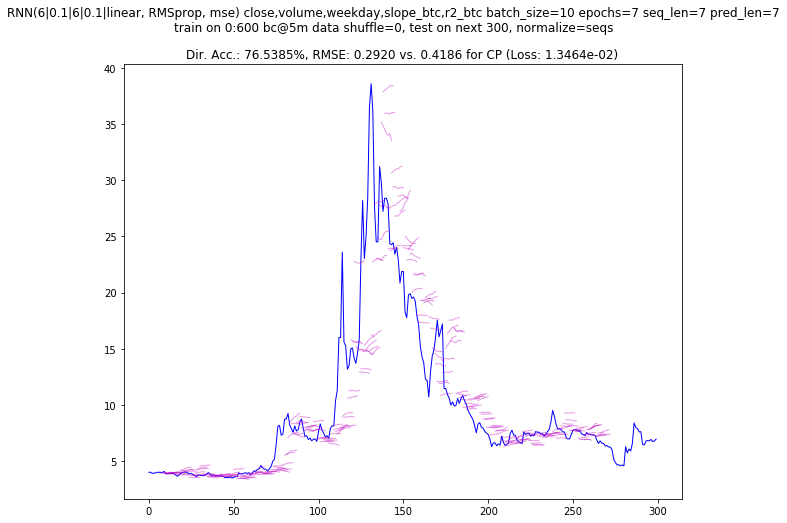

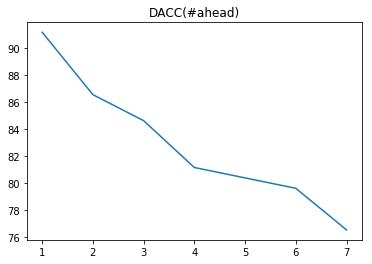

--- 46.710s to run segment

--- 46.710s to full run 600 - 645



        #################################
        # amd
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 5)
--- 0.028s to model compilation time


--- Created model id: 140035523246992
Tensor("lstm_277_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_277 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_277 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_278 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_278 (Dropout)        (None, 6)                 0         
__________________________

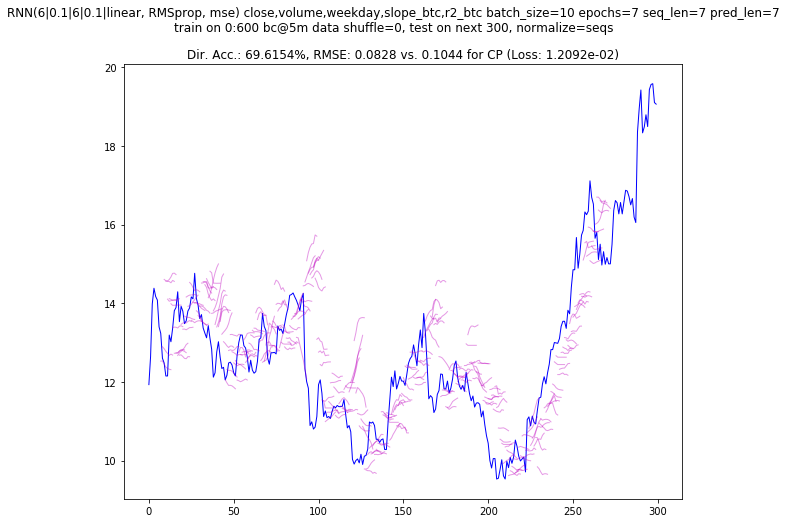

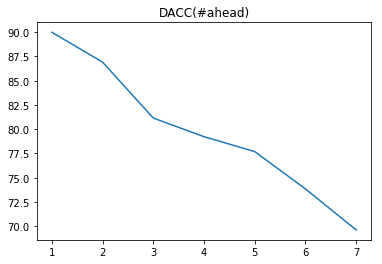

--- 44.424s to run segment

--- 44.425s to full run 600 - 645



        #################################
        # otiv
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 5)
--- 0.019s to model compilation time


--- Created model id: 140035499775120
Tensor("lstm_279_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_279 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_279 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_280 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_280 (Dropout)        (None, 6)                 0         
_________________________

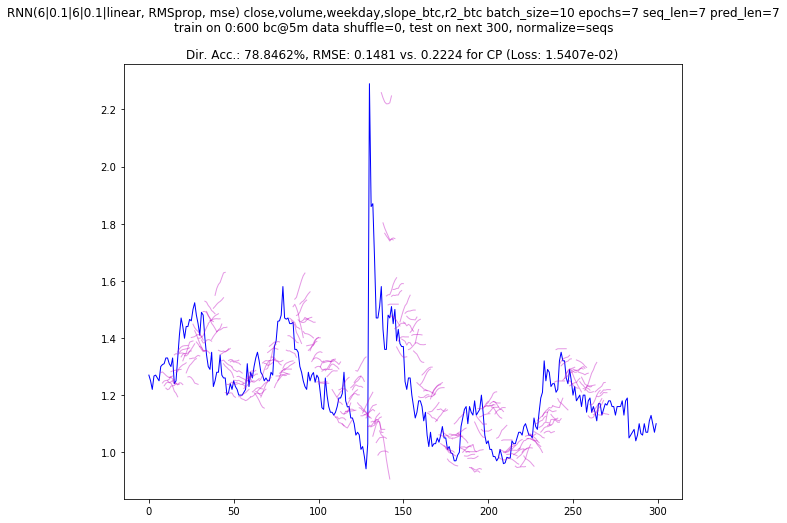

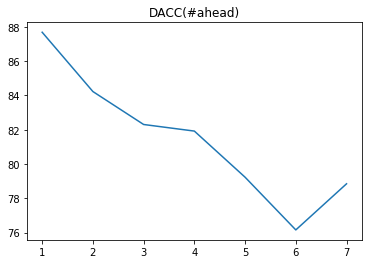

--- 43.872s to run segment

--- 43.872s to full run 600 - 645



        #################################
        # nvda
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 5)
--- 0.023s to model compilation time


--- Created model id: 140035476768976
Tensor("lstm_281_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_281 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_281 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_282 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_282 (Dropout)        (None, 6)                 0         
_________________________

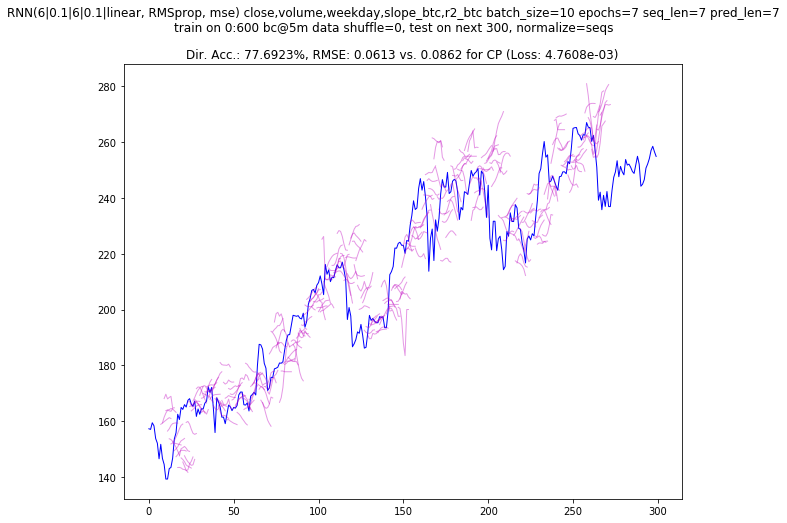

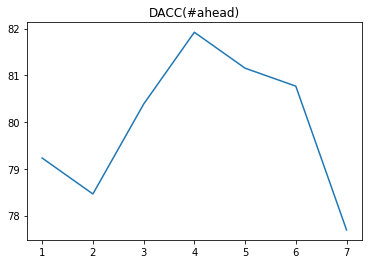

--- 44.945s to run segment

--- 44.945s to full run 600 - 645



        #################################
        # sieb
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 5)
--- 0.019s to model compilation time


--- Created model id: 140035454712144
Tensor("lstm_283_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_283 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_283 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_284 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_284 (Dropout)        (None, 6)                 0         
_________________________

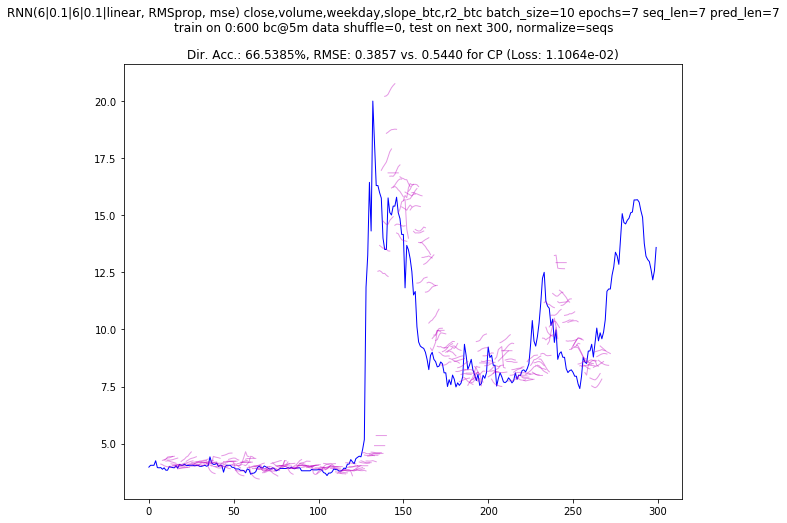

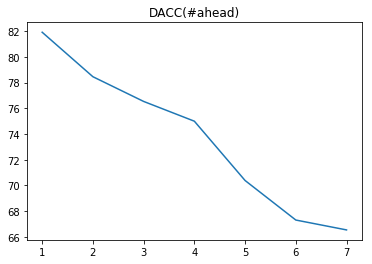

--- 148.202s to run segment

--- 148.203s to full run 600 - 645



        #################################
        # gbtc
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 5)
--- 0.032s to model compilation time


--- Created model id: 140036124419920
Tensor("lstm_285_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_285 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_285 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_286 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_286 (Dropout)        (None, 6)                 0         
_______________________

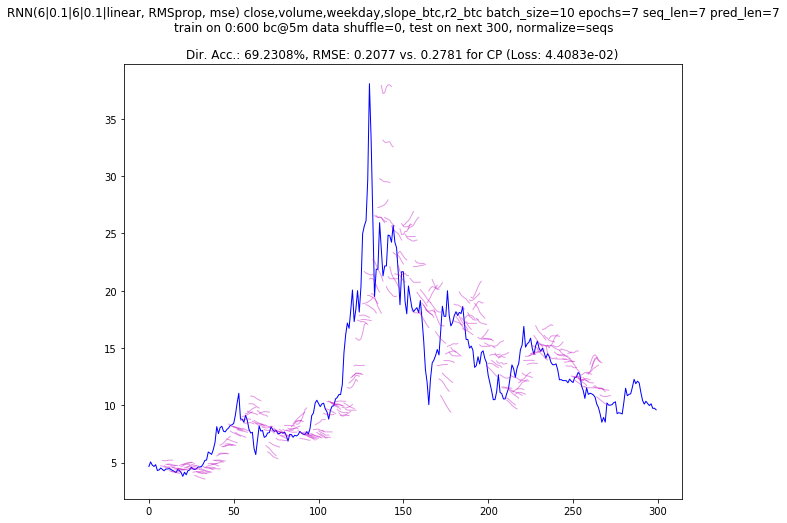

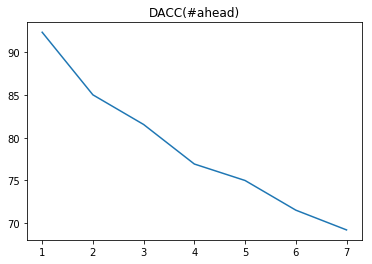

--- 48.323s to run segment

--- 48.324s to full run 600 - 645



        #################################
        # mara
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 5)
--- 0.029s to model compilation time


--- Created model id: 140035950592336
Tensor("lstm_287_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_287 (LSTM)              (None, 7, 6)              288       
_________________________________________________________________
dropout_287 (Dropout)        (None, 7, 6)              0         
_________________________________________________________________
lstm_288 (LSTM)              (None, 6)                 312       
_________________________________________________________________
dropout_288 (Dropout)        (None, 6)                 0         
_________________________

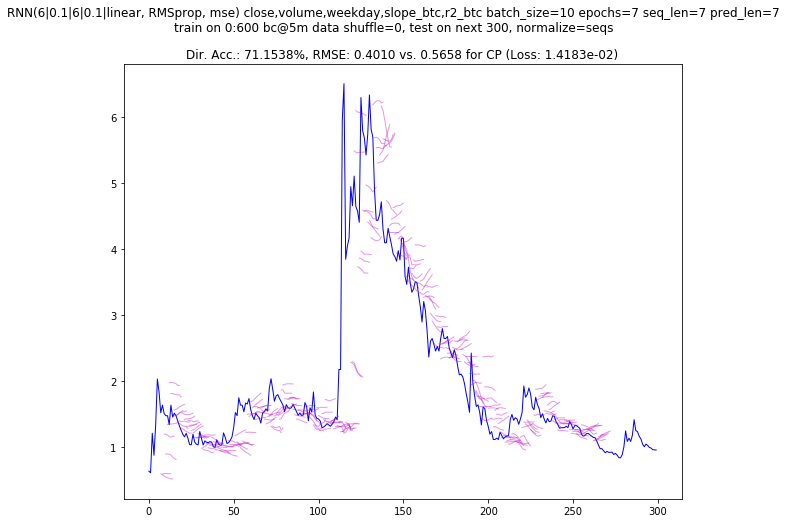

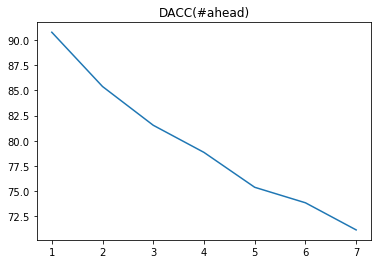

--- 47.904s to run segment

--- 47.905s to full run 600 - 645



In [64]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    full_run(600, len(data) - 300, data,
             out_filename='./results/stock_%s_all.csv' % stock,
             write_csv_header=True)

In [65]:
results = {}
for stock in STOCKS:
    r = pd.read_csv('./results/stock_%s_all.csv' % stock)
    r['rmse'] = r['rmse'].str.replace('%', '').astype(float)
    r['rmse_cp'] = r['rmse_cp'].str.replace('%', '').astype(float)
    r['dir_acc'] = r['dir_acc'].str.replace('%', '').astype(float)
    print("\n\n---------")
    print("> stock %s: RMSE=%.4f%% (vs. %.4f%% for CP), DACC=%.2f%%" % (
        stock.upper(),
        r['rmse'].mean(), 
        r['rmse_cp'].mean(),
        r['dir_acc'].mean(),
    ))
    dd(r)
    results[stock] = r



---------
> stock AMD: RMSE=0.0828% (vs. 0.1044% for CP), DACC=69.62%


,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(6|0.1|6|0.1|linear, RMSprop, mse) close,vo...",0,600,300,False,seqs,0.012092,0.0828,0.1044,69.6154




---------
> stock NVDA: RMSE=0.0613% (vs. 0.0862% for CP), DACC=77.69%


,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(6|0.1|6|0.1|linear, RMSprop, mse) close,vo...",0,600,300,False,seqs,0.004761,0.0613,0.0862,77.6923




---------
> stock GBTC: RMSE=0.2077% (vs. 0.2781% for CP), DACC=69.23%


,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(6|0.1|6|0.1|linear, RMSprop, mse) close,vo...",0,600,300,False,seqs,0.044083,0.2077,0.2781,69.2308




---------
> stock MARA: RMSE=0.4010% (vs. 0.5658% for CP), DACC=71.15%


,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(6|0.1|6|0.1|linear, RMSprop, mse) close,vo...",0,600,300,False,seqs,0.014183,0.401,0.5658,71.1538




---------
> stock OSTK: RMSE=0.1560% (vs. 0.2261% for CP), DACC=73.85%


,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(6|0.1|6|0.1|linear, RMSprop, mse) close,vo...",0,600,300,False,seqs,0.004351,0.156,0.2261,73.8462




---------
> stock OTIV: RMSE=0.1481% (vs. 0.2224% for CP), DACC=78.85%


,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(6|0.1|6|0.1|linear, RMSprop, mse) close,vo...",0,600,300,False,seqs,0.015407,0.1481,0.2224,78.8462




---------
> stock RIOT: RMSE=0.2920% (vs. 0.4186% for CP), DACC=76.54%


,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(6|0.1|6|0.1|linear, RMSprop, mse) close,vo...",0,600,300,False,seqs,0.013464,0.292,0.4186,76.5385




---------
> stock SIEB: RMSE=0.3857% (vs. 0.5440% for CP), DACC=66.54%


,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(6|0.1|6|0.1|linear, RMSprop, mse) close,vo...",0,600,300,False,seqs,0.011064,0.3857,0.544,66.5385
